In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [2]:
# import estimator class
from estimators.rnnEstimator import RnnEstimator
from estimators.kalmanEstimator import KalmanEstimator
from estimators.particleFilterEstimator import ParticleFilterEstimator

#import rewarder class
from rewarders.thresholdRewarder import ThresholdRewarder

from matplotlib import pyplot
from utils.sequences_treatment import *
from utils.agent_treatment import *
from utils.plots import *
from utils.save import *

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

In [3]:
# Facultatively load a workspace
workspace_path=None #'workspaces/20210723-134410' # None or workspace_path (workspaces/...)

if workspace_path is not None:
    load_workspace(workspace_path, globals())
    print('Wokspace loaded.')
else:
    print('No workspace loaded.')

No workspace loaded.


In [4]:
# Set parameters
estimatorType='rnn' # kalman, particle or rnn

seeAction=True
seeMeasurement=False
seeEstimate=False
seeTime=True
seeSumAction = True

T=12+1

threshold=4
windowSize=T


if estimatorType=='kalman':
    cost=50 # tumor_benchmark: 0 < cost=? < ?   classic_benchmark: 0 < cost=50 < 100
elif estimatorType=='particle':
    if seeMeasurement:
        cost=1000 
    else:
        cost=1000 # 0 < cost=? < 1000
elif estimatorType=='rnn':
    cost=500
print("cost=",cost)

cost= 500


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1840      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
dense (Dense)                (None, None, 1)           21        
Total params: 5,141
Trainable params: 5,141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
400/400 - 3s - loss: 138.5526 - val_loss: 125.4013
Epoch 2/20
400/400 - 2s - loss: 120.3890 - val_loss: 116.4907
Epoch 3/20
400/400 - 2s - loss: 113.7491 - val_loss: 112.4373
Epoch 4/20
400/400 - 2s - loss: 109.6977 - val_loss: 109.1631
Epoch 5/20
400/400 - 2s - loss: 107.1667 - val_loss: 107.8825
Epoch 6/20
400/400 - 2s - loss: 105.6438 - val_loss: 105.5964
Epoch 7/20
4

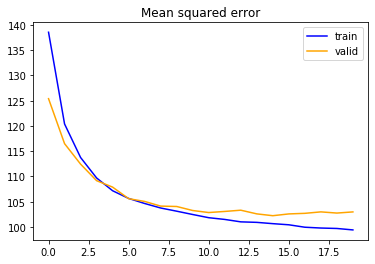

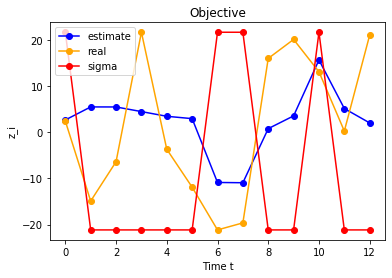

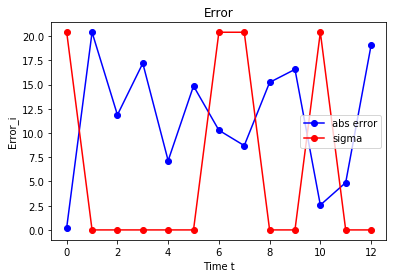

Done


In [5]:
if estimatorType=='rnn' and 'model' not in dir(): # if a RNN model has not been loaded
    # construct and train a Sequential RNN model with keras
    numberSamples_trainRNN=500
    T_trainRNN=T
    generatorType='particle'

    # generate sequences for training
    (objectives_trainRNN,measurements_trainRNN)=generateSequence(T_trainRNN,numberSamples=numberSamples_trainRNN,generatorType=generatorType)
    sigmas_trainRNN=randomSigma(T_trainRNN,numberSamples=numberSamples_trainRNN,p0=1-threshold/windowSize)
    measurements_corrupted_trainRNN=corruptSequence_outOfRange(measurements_trainRNN,sigmas_trainRNN)
    
    # new
    inputRNN=np.concatenate((np.expand_dims(sigmas_trainRNN,2),measurements_corrupted_trainRNN),axis=2)
    
    n_dim_meas=np.shape(measurements_corrupted_trainRNN)[2]
    n_dim_obj=np.shape(objectives_trainRNN)[2]

    model=Sequential()
    model.add(Input(shape=(None,n_dim_meas+1)))
    model.add(LSTM(20,return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(Dense(n_dim_obj,activation=None))

    model.compile(optimizer='adam',loss='mean_squared_error')
    model.summary()

    # train the RNN
    n_epochs_RNN=20
    history=model.fit(x=inputRNN,y=objectives_trainRNN,batch_size=1,epochs=n_epochs_RNN,validation_split=0.2,verbose=2)

    # plot loss
    plotRNNresults(history)
    
    idx_sample=0
    estimates_trainRNN=model.predict(inputRNN)
    plotExperiment(objectives_trainRNN, estimates_trainRNN, sigmas_trainRNN,idx_sample=idx_sample)
print('Done')

In [6]:
# construct estimator
if estimatorType=='rnn':
    estimator=RnnEstimator(T,windowSize,threshold,model,generatorType,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime,seeSumAction=seeSumAction)
elif estimatorType=='kalman':
    estimator=KalmanEstimator(T,windowSize,threshold,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime,seeSumAction=seeSumAction)
elif estimatorType == 'particle':
    estimator=ParticleFilterEstimator(T,windowSize,threshold,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime,seeSumAction=seeSumAction)
else:
    print('ERROR: no valid estimatorType')
    
estimator.summarize()

RNN estimator
  observationsDimensions: [(12,), (1,), (1,)]
  seeAction= True
  seeMeasurement= False
  seeEstimate= False
  seeTime= True
  seeSumAction= True


In [7]:
# contruct rewarder
rewarder=ThresholdRewarder(threshold=threshold, cost=cost, windowSize=windowSize)
rewarder.summarize()

Threshold rewarder
  window size: 13
  threshold: 4
  cost: 500
  number of measures in the window: 0


In [8]:
# generate sequences for training and validating the agent
numberSamples_train=50
T_train=T

numberSamples_valid=numberSamples_train
T_valid=T_train

if workspace_path is None: # data have not been loaded
    (objectives_train,measurements_train)=estimator.generateSequence(T_train,numberSamples=numberSamples_train)
    (objectives_valid,measurements_valid)=estimator.generateSequence(T_valid,numberSamples=numberSamples_valid)
    print('New data generated')
else:
    print('No new data generated')

#print('----- TO REMOVE -----')
#objectives_valid = objectives_train
#measurements_valid = measurements_train

print('shape training objectives:',np.shape(objectives_train))
print('shape training measurements:',np.shape(measurements_train))
print('shape validating objectives:',np.shape(objectives_valid))
print('shape validating measurements:',np.shape(measurements_valid))

New data generated
shape training objectives: (50, 13, 1)
shape training measurements: (50, 13, 1)
shape validating objectives: (50, 13, 1)
shape validating measurements: (50, 13, 1)


In [9]:
# construct agent
agent=constructAgent(estimator,rewarder,objectives_train,measurements_train,objectives_valid,measurements_valid)

agent._learning_algo.q_vals.summary()

print('Agent constructed')

Environment parameters
  inputDimensions= [(12,), (1,), (1,)]
Sequences parameters
  outOfRangeValue= -1
  n_dim_obj= 1
  n_dim_meas= 1
  numberSamples_train 50
  numberSamples_valid 50
RNN estimator
  observationsDimensions: [(12,), (1,), (1,)]
  seeAction= True
  seeMeasurement= False
  seeEstimate= False
  seeTime= True
  seeSumAction= True
Threshold rewarder
  window size: 13
  threshold: 4
  cost: 500
  number of measures in the window: 0
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 12, 1)     0           input_2[0][0]                    
___________________________________

In [ ]:
# Train agent
n_epochs_agent=5

agent.resumeTrainingMode() # not required

start_time = time.time()
agent.run(n_epochs=n_epochs_agent, epoch_length=numberSamples_train*T_train)
elapsed_time = time.time() - start_time

cumulatedRewards_valid=agent._controllers[-1].rewards # interleavedValidEpochController is the last controller.
print('Agent Trained (in',elapsed_time,'seconds)')

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
in

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -22]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 13]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -24]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -23]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 18]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 20]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -13]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 22]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 22]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 24]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 21]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 21]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 25]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -13]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -18]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=i

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -20]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -22]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 19]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 19]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=i

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -19]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -21]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 20]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -22]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 19]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 13]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 20]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 19]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 22]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -18]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -18]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -18]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -18]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -20]]], shape=(1, 1, 2), dtype

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -18]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -13]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -13]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -13]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -13]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dty

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -13]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 20]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 26]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 20]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 18]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 21]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -13]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 13]]], shape=(1, 1, 2), dty

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -24]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 19]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 18]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 18]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 24]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 21]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -13]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 20]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -23]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -23]]], shape=(1, 1, 2), dtype=int64

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 19]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dty

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -13]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 19]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 17]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -13]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 13]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 16]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 17]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 19]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 21]]], shape=(1, 1, 2), dtype=int64)
Validation epoch running... input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]]

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -20]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -22]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 19]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 19]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 19]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 25]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -24]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -15]]], shape=(1, 1, 2), dtype

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 22]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -23]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 18]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 0]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 9]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 21]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 13]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 5]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 24]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -16]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -12]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -10]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 15]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 4]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -5]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -17]]], shape=(1, 1, 2), dtype=int

input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 14]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -6]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 2]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[  1 -11]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 8]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 0 -1]]], shape=(1, 1, 2), dtype=int64)


input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -1]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 3]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[ 1 -7]]], shape=(1, 1, 2), dtype=int64)
input shape: (1, 1, 2)
tensor shape: (1, 1, 2)
tf.Tensor([[[1 7]]], shape=(1, 1, 2), dtype=int64)


In [ ]:
# plot validation
#boxplotCumulatedRewards(cumulatedRewards_valid)
plotAllCumulatedRewards(cumulatedRewards_valid)
allHistoCumulatedRewards(cumulatedRewards_valid)

meanReward_valid=np.mean(cumulatedRewards_valid[-1])
print('meanReward_valid: ',meanReward_valid)

In [ ]:
# generate test data
numberSamples_test=numberSamples_train
T_test=T
    
if workspace_path is None: # data have not been loaded
    (objectives_test,measurements_test)=estimator.generateSequence(T_test,numberSamples=numberSamples_test)
    print('New data generated')
else:
    print('No new data generated')

#print('----- TO REMOVE -----')
#objectives_test = objectives_train
#measurements_test = measurements_train


# Results of the inference on test data
(sigmas_test,rewards_test,estimates_test)=agentInference(agent,objectives_test,measurements_test)
print('Test results computed')

In [ ]:
# plot test
idx_sample=0
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_test)
boxplotErrors(objectives_test,estimates_test)
#plotAllErrors(objectives_test,estimates_test)
boxplotRewards(rewards_test)
#plotAllRewards(rewards_test)
histoCumulatedRewards(rewards_test)

meanReward_test=np.mean(rewards_test)
print('meanReward_test: ',meanReward_test)

sumSigmas_test=np.sum(sigmas_test,axis=1)
print('sumSigmas_test',sumSigmas_test)

In [ ]:
# regular run on test data (default case without agent)
numberMeasurements=int(np.ceil(threshold/windowSize*T))

# compute regular sigma (with same dim than validation data)
sigmas_regular=regularSigma(T_valid,numberMeasurements,numberSamples=numberSamples_test)

(rewards_regular, estimates_regular)=agentForcedInference(agent, sigmas_regular)
print('Done.')

In [ ]:
# plot test regular
idx_sample=5
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_regular)
boxplotErrors(objectives_test,estimates_regular)
#plotAllErrors(objectives_test,estimates_regular)
boxplotRewards(rewards_regular)
#plotAllRewards(rewards_regular)
histoCumulatedRewards(rewards_regular)
meanReward_regular=np.mean(rewards_regular)
print('meanReward_regular: ',meanReward_regular)

In [ ]:
toSave=["estimatorType","seeAction","seeMeasurement","seeEstimate","seeTime","T","threshold","windowSize","cost"]
if estimatorType=='rnn':
    toSave.extend(["numberSamples_trainRNN","T_trainRNN","generatorType","objectives_trainRNN","measurements_trainRNN","n_epochs_RNN","model","history","estimates_trainRNN"])
toSave.extend(["estimator","rewarder"])
toSave.extend(["numberSamples_train","T_train","numberSamples_valid","T_valid","objectives_train","measurements_train","objectives_valid","measurements_valid"])
toSave.extend(["agent","n_epochs_agent"])
toSave.extend(["cumulatedRewards_valid","meanReward_valid"])
toSave.extend(["numberSamples_test","T_test","objectives_test","measurements_test","sigmas_test","rewards_test","estimates_test"])
toSave.extend(["meanReward_test","sumSigmas_test"])
toSave.extend(["numberMeasurements","sigmas_regular","rewards_regular","estimates_regular","meanReward_regular"])
save_workspace('workspaces/',toSave,globals())

In [ ]:
import os
os.system("say Au travail faignant.")

In [ ]:
agent.discountFactor()

In [ ]:
agent._learning_algo.__dict__